# 通し課題 Day３
## 目的
 課題①　KickStarter Project　
 https://www.kaggle.com/kemical/kickstarter-projects
 
 について分類アルゴリズムを実装評価する。
 
　DAY2で発生していた状況は以下の通り
- SVMであまり精度が出ない

対策として、もう少しハイパーパラメータ探索の幅を広げてみる

 
 また、DAY3で学んだ以下の項目についてkickstarterでも実施する
- 特徴量削減
- 決定木、ランダムフォレスト、アダブーストの実装
- ニューラルネットの実装
 

## 前準備
DAY2と同様にデータの読込＋加工+標準化を行う

In [1]:
#必要なライブラリのインポート
#各種必要ライブラリのロード
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from common_func import plot_decision_regions
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

In [2]:
#データの読込
df = pd.read_csv("./ks-projects-201801.csv")

#評価基準の統一のため、データの加工方法を統一する
df = df[df["state"]!="live"]
df["state"] = df["state"]=="successful"

#開始時にはわからないデータを除去する
df = df.drop('pledged', axis=1)
df = df.drop('backers', axis=1)
df = df.drop('usd pledged', axis=1)
df = df.drop('usd_pledged_real', axis=1)

df_input = pd.concat([df, pd.get_dummies(df['main_category'])], axis=1)
df_input = pd.concat([df_input, pd.get_dummies(df_input['currency'])], axis=1)
df_input = pd.concat([df_input, pd.get_dummies(df_input['country'])], axis=1)

y = df_input["state"].values

inp = df_input.drop(['state','ID', 'name','category','deadline','launched', 'main_category', 'currency', 'country'], axis=1)
X = inp.values
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234)

## DAY2の続き
- 学習用を1%にし、評価用を99%にする（使用しないデータが勿体無い）
- 上記の分割をした上でSVMのハイパーパラメータ探索範囲を広げ、もう少し精度が上がらないかどうかをみてみる

In [3]:
#学習用データと検証用データ
test_size = 0.01        # 全データのうち、何%をテストデータにするか（今回は20%に設定）
X_test2, X_train2, y_test2, y_train2 = train_test_split(X_train, y_train, test_size=test_size, random_state=1234) # ホールドアウト法を実行（テストデータはランダム選択）

In [7]:
# 標準化
from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train2)
X_test_std = stdsc.transform(X_test2)
#最終評価用データの標準化
X_fin_Test_std = stdsc.transform(X_test)

In [8]:
print(X_train_std.shape)
print(y_train2.shape)

(3007, 54)
(3007,)


In [13]:
%%time
parameters = {'kernel':['rbf'], 'C':[0.2,0.25,0.3], 'gamma':[0.5,0.6]} # ここを編集する
model = SVC()
clf = GridSearchCV(model, parameters, cv=3,)
clf.fit(X_train_std, y_train2)
print(clf.best_params_, clf.best_score_)

{'C': 0.3, 'gamma': 0.5, 'kernel': 'rbf'} 0.6501496508147655
CPU times: user 11 s, sys: 67.6 ms, total: 11.1 s
Wall time: 11.3 s


In [14]:
# 最適パラメータを用いて識別する
clf2 = SVC(**clf.best_params_)
clf2.fit(X_train_std, y_train2)
print("識別精度=",clf2.score(X_fin_Test_std, y_test))

識別精度= 0.6514706077980126


## DAY2の再検討
- ハイパーパラメータの探索範囲を増やす

In [15]:
%%time
parameters = {'kernel':['rbf'], 'C':[0.01, 0.1, 0.5, 1, 1.5, 2.0, 2.5, 3.0, 10, 20, 30], 'gamma':[0.01,0.1, 1.0, 5.0, 10, 20, 30]} # ここを編集する
model = SVC()
clf = GridSearchCV(model, parameters, cv=3,)
clf.fit(X_train_std, y_train2)
print(clf.best_params_, clf.best_score_)

{'C': 0.5, 'gamma': 30, 'kernel': 'rbf'} 0.660458929165281
CPU times: user 2min 20s, sys: 546 ms, total: 2min 21s
Wall time: 2min 23s


In [16]:

# 最適パラメータを用いて識別する
clf2 = SVC(**clf.best_params_)
clf2.fit(X_train_std, y_train2)
print("識別精度=",clf2.score(X_fin_Test_std, y_test))

識別精度= 0.6576031287829407


In [17]:
%%time
parameters = {'kernel':['rbf'], 'C':[0.01, 0.1, 0.5, 1, 1.5, 2.0, 2.5, 3.0, 10, 20, 30], 'gamma':[10, 20, 30, 50, 100, 200, 300]} # ここを編集する
model = SVC()
clf = GridSearchCV(model, parameters, cv=3,)
clf.fit(X_train_std, y_train2)
print(clf.best_params_, clf.best_score_)

{'C': 0.5, 'gamma': 100, 'kernel': 'rbf'} 0.662454273362155
CPU times: user 2min 26s, sys: 1.07 s, total: 2min 27s
Wall time: 2min 34s


In [19]:
# 最適パラメータを用いて識別する
clf2 = SVC(**clf.best_params_)
clf2.fit(X_train_std, y_train2)
print("識別精度=",clf2.score(X_fin_Test_std, y_test))

識別精度= 0.6586141300732976


### 結果の考察
- ハイパーパラメータを調整することにより、精度は65.2% から　65.8% に向上した。
- ハイパーパラメータが極端な値になっているように見える
- SVMとパラメータ調整のみでは,これ以上の精度向上は厳しい

### DAY3の項目の実装

### LASSOによる特徴量削減
- Logistic回帰（LASSO）を行い、特徴量削減を行う

In [21]:
#logistic回帰＋LASSOで変数選択し、SVCで学習する
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel

model = SVC(kernel='rbf', C=30, gamma=300)
C_list = [i*0.01 for i in range(1, 100, 1)]
result_pf = pd.DataFrame(columns=['C', 'SCORE'])

for C in C_list:
    clf = LogisticRegression(C=C, penalty='l1')
    clf.fit(X_train_std, y_train2)
    slm = SelectFromModel(clf, prefit=True)
    
    print(slm.get_support())
    
    #選択特徴量の抽出
    train_x_data = X_train_std[:, slm.get_support()]
    test_x_dat = X_fin_Test_std[:, slm.get_support()]
    print(train_x_data.shape)
    print(X_train_std.shape)
    
    #SVC
    model.fit(train_x_data, y_train2)
    score = model.score(test_x_dat, y_test)
    print("C:" + str(C) + ", score = " + str(score))
    
    tmp_se = pd.Series( [ C, score ], index=result_pf.columns )
    result_pf = result_pf.append( tmp_se , ignore_index=True)

[False False False False False False False  True False False False False
  True False False  True False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False  True
 False False False False False  True]
(3007, 5)
(3007, 54)
C:0.01, score = 0.644180756388597
[ True False False  True False  True False  True False  True False False
  True False  True  True  True False False False False False False False
 False  True False False False False False False False False  True False
 False False False False False False False  True False False  True  True
 False False False False False  True]
(3007, 15)
(3007, 54)
C:0.02, score = 0.6626847405318399
[ True False False  True False  True  True  True False  True False  True
  True  True  True  True  True False False False False False  True False
 False  True False False False False False False False False  True False
 False Fa

C:0.22, score = 0.6536655448099716
[ True  True False  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True False  True False False  True  True
 False  True  True False False False False  True False False  True  True
  True False  True  True False  True  True  True False False  True  True
  True  True  True False False  True]
(3007, 37)
(3007, 54)
C:0.23, score = 0.6536655448099716
[ True  True False  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True False  True False False  True  True
 False  True  True False False False False  True False False  True  True
  True False  True  True False  True  True  True False False  True  True
  True  True  True False False  True]
(3007, 37)
(3007, 54)
C:0.24, score = 0.6536655448099716
[ True  True False  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True False  True False False  True  True
 False  True  True False False False False  T

C:0.44, score = 0.6536655448099716
[ True  True False  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True False  True False False  True  True
 False  True  True False False False False  True False False  True  True
  True False  True  True False  True  True  True False False  True  True
  True  True  True False False  True]
(3007, 37)
(3007, 54)
C:0.45, score = 0.6536655448099716
[ True  True False  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True False  True False False  True  True
 False  True  True False False False False  True False False  True  True
  True False  True  True False  True  True  True False False  True  True
  True  True  True False False  True]
(3007, 37)
(3007, 54)
C:0.46, score = 0.6536655448099716
[ True  True False  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True False  True False False  True  True
 False  True  True False False False False  T

C:0.66, score = 0.653638939512857
[ True  True False  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True False False  True  True
 False  True  True False False False False  True False False  True  True
  True False  True  True False  True  True  True False False  True  True
  True  True  True False False  True]
(3007, 38)
(3007, 54)
C:0.67, score = 0.653638939512857
[ True  True False  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True False False  True  True
 False  True  True False False False False  True False False  True  True
  True False  True  True False  True  True  True False False  True  True
  True  True  True False False  True]
(3007, 38)
(3007, 54)
C:0.68, score = 0.653638939512857
[ True  True False  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True False False  True  True
 False  True  True False False False False  True

C:0.88, score = 0.6539315977811182
[ True  True False  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True False  True False
 False  True  True False  True  True False  True False  True  True  True
  True  True  True  True False  True  True  True False False  True  True
  True  True  True  True  True  True]
(3007, 44)
(3007, 54)
C:0.89, score = 0.6539315977811182
[ True  True False  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True False  True  True
 False  True  True False  True  True False  True False  True  True  True
  True  True  True  True False  True  True  True False False  True  True
  True  True  True  True  True  True]
(3007, 45)
(3007, 54)
C:0.9, score = 0.6539315977811182
[ True  True False  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True False  True  True
 False  True  True False  True  True False  Tr

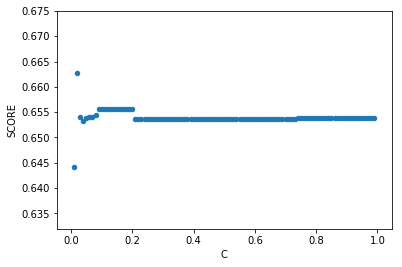

In [22]:
result_pf.plot.scatter(x='C', y='SCORE')

- LASSOによる変数選択によっても, SVMでは大きく精度が向上はしていない

## 決定木
本データに対して、決定木で学習し、変数の重要度を確認してみる

In [42]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
clf = DecisionTreeClassifier(criterion="gini", max_depth=None, min_samples_split=2, min_samples_leaf=1, random_state=1234)
#決定木の場合は標準化が不要のため、標準化を実施せずに実行する
clf = clf.fit(X_train, y_train)
print("validation score=", clf.score(X_test, y_test))
print("training score=", clf.score(X_train, y_train))

validation score= 0.6540912295638062
training score= 0.744885912022056


[1.84789200e-01 5.81066370e-01 7.18398489e-03 1.17308174e-02
 6.42264133e-03 8.88197977e-03 8.38470678e-03 1.21718417e-02
 1.15717943e-02 5.48452843e-03 9.93905692e-03 2.58446211e-03
 1.97737199e-02 4.58102450e-03 6.18818295e-03 9.15041545e-03
 1.91770898e-02 2.62124178e-03 2.90914293e-03 7.40260185e-04
 4.43672608e-04 5.19536073e-03 2.54169379e-03 2.82744612e-04
 7.76726799e-06 3.16221785e-04 4.67926323e-04 1.08887841e-03
 6.25434373e-04 7.99614846e-04 3.95698703e-03 1.07651037e-03
 2.94275177e-03 1.19175133e-03 3.65967903e-03 5.97324620e-04
 2.93628956e-03 7.21788773e-04 3.23032452e-03 3.13386033e-03
 2.11513687e-03 9.24539411e-04 1.91917634e-03 2.99968624e-03
 9.46120660e-05 3.48024386e-04 5.43403381e-04 2.54417136e-02
 3.17348756e-03 5.45650811e-04 1.31943485e-03 1.11895105e-03
 6.62081476e-04 8.22505920e-03]


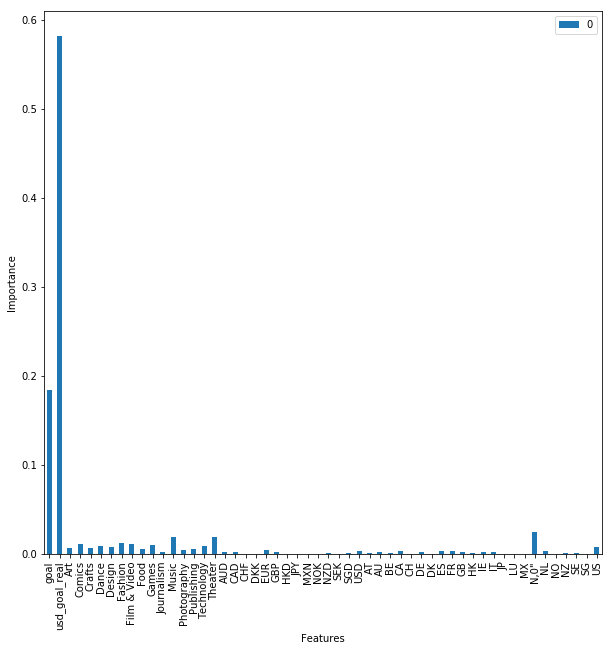

In [43]:
column = inp.columns
print(clf.feature_importances_)
pd.DataFrame(clf.feature_importances_, index=column).plot.bar(figsize=(10,10))
plt.ylabel("Importance")
plt.xlabel("Features")
plt.show()

#### 決定木の考察
- 3種のアルゴリズムで同様の結果となっているため、データに起因した要因によって精度が悪化している可能性がある
- 決定木でTrainigScoreを最大にするように学習したが、74%の精度しかない（＝アンダーフィッティングの状態）

- 変数重要度を確認すると、極端にgoalの値に偏ったモデルになっているように見える
- DAY1の解析結果から金額の大小は正否に多少の影響があるが、金額が大きくなるほど差が小さくなっており、これだけに依存しているのはよくないと判断する
- SVMなど他のアルゴリズムでも金額以外のデータがうまく使えていない可能性がある

- 一度金額を外したデータで学習し、他のデータが分類にどの程度影響しているのかを確認する
- 過学習が原因であるならば、random forestなどの弱識別器による学習を試してみる

### 金額を除去したデータでの決定木解析
- goalに依存しないモデルを作成し、結果を確認する

In [33]:
#goalの値を除去したデータを作成する
X_train_g = X_train[:,2:]
X_test_g = X_test[:,2:]
print(X_train_g.shape)
print(X_test_g.shape)

(300689, 52)
(75173, 52)


In [44]:
clf = DecisionTreeClassifier(criterion="gini", max_depth=None, min_samples_split=2, min_samples_leaf=1, random_state=1234)
#決定木の場合は標準化が不要のため、標準化を実施せずに実行する
clf = clf.fit(X_train_g, y_train)
print("Validation score=", clf.score(X_test_g, y_test))
print("Training score=", clf.score(X_train_g, y_train))

Validation score= 0.6557540606334721
Training score= 0.6562627831413853


[1.18076540e-02 8.82134115e-02 2.20480300e-02 6.26637424e-02
 4.29908303e-03 4.06767922e-02 1.08557682e-03 3.88893312e-02
 1.58036800e-03 1.90101307e-02 1.38756854e-01 6.68389850e-03
 1.95701210e-02 1.74045421e-01 1.19304415e-01 1.24237592e-03
 6.58801569e-03 1.18610606e-03 1.89099029e-03 2.37065242e-02
 5.17875012e-03 1.67944702e-04 2.81157125e-04 1.27354962e-03
 2.90611122e-04 3.74354306e-04 6.07004671e-04 4.66597603e-04
 1.58000700e-02 5.39988934e-04 4.50379581e-03 6.38662907e-04
 1.40990882e-03 1.59518774e-04 2.37099060e-03 5.28026952e-04
 1.21096485e-03 4.27874164e-03 5.54910328e-03 3.22552342e-03
 3.15323153e-04 4.17475674e-03 1.41518636e-04 7.15878219e-04
 2.17918169e-03 1.29200211e-01 5.01798085e-04 1.14013263e-03
 8.23793860e-04 1.40017062e-03 1.20470347e-03 2.60984258e-02]


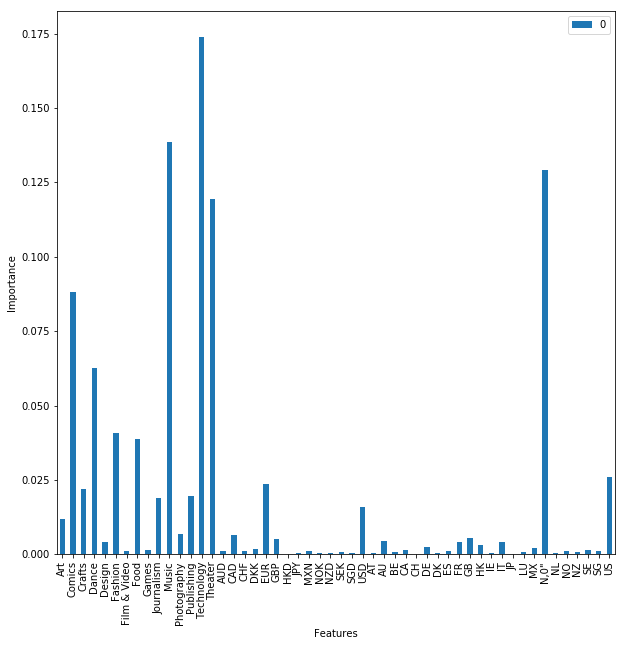

In [45]:
column = inp.columns
print(clf.feature_importances_)
pd.DataFrame(clf.feature_importances_, index=column[2:]).plot.bar(figsize=(10,10))
plt.ylabel("Importance")
plt.xlabel("Features")
plt.show()

#### 結果の考察
- 変数重要度について、多少の変動はあるものの概ね同じに見える
- goalを外した状態では、TraingScoreは悪化し、Validation Scoreはほとんど変動しなかった
- モデルとしては説明変数が足りていない可能性がある
- モデルの表現力が不足している？（もう少し複雑なモデルで試してみる）


### RandomForest
モデルの表現力が不足しているため、精度が落ちているのかどうかをRandomForestと比較することで確認する

In [51]:
from sklearn.ensemble import RandomForestClassifier

n_est_list = [1,10,50,100]
max_depth_list = [1,10,50,100]

res_df = pd.DataFrame(columns=['n_est', 'max_dep', 'validation', 'training'])


for n_est in n_est_list:
    for max_dep in max_depth_list:
        clf = RandomForestClassifier(n_estimators=n_est, max_depth=max_dep, criterion="gini",
                                                 min_samples_leaf=1, min_samples_split=2, random_state=1234)
        clf.fit(X_train, y_train)
        print("Validation score=", clf.score(X_test, y_test))
        print("Training score=", clf.score(X_train, y_train))
        tmp_se = pd.Series( [ n_est, max_dep, clf.score(X_test, y_test), clf.score(X_train, y_train) ], index=res_df.columns )
        res_df = res_df.append( tmp_se , ignore_index=True)


Validation score= 0.6448591914650207
Training score= 0.6432892456990446
Validation score= 0.6617003445385976
Training score= 0.6632134863596606
Validation score= 0.6516036342835858
Training score= 0.7120978818646508
Validation score= 0.6523219773056815
Training score= 0.7120978818646508
Validation score= 0.6448591914650207
Training score= 0.6432892456990446
Validation score= 0.669469091296077
Training score= 0.6706098327507823
Validation score= 0.6576031287829407
Training score= 0.7366248848477995
Validation score= 0.6575898261343833
Training score= 0.7365350910741664
Validation score= 0.6448591914650207
Training score= 0.6432892456990446
Validation score= 0.6679924973062137
Training score= 0.6701941208358138
Validation score= 0.6564058904127812
Training score= 0.7443870577240936
Validation score= 0.655953600361832
Training score= 0.744383732028774
Validation score= 0.6448591914650207
Training score= 0.6432892456990446
Validation score= 0.6684713926542775
Training score= 0.669302834490

In [55]:
#TrainingScoreが大きくなる組み合わせを探すためにTraingScoreを整形して確認
res_df['training'].values.reshape(4,4)

array([[0.64328925, 0.66321349, 0.71209788, 0.71209788],
       [0.64328925, 0.67060983, 0.73662488, 0.73653509],
       [0.64328925, 0.67019412, 0.74438706, 0.74438373],
       [0.64328925, 0.66930283, 0.74481607, 0.74480942]])

[2.59281124e-01 5.48681787e-01 3.47889085e-03 9.98627392e-03
 8.78771375e-03 8.05231472e-03 4.64579476e-03 1.22388884e-02
 5.37952490e-03 8.22772548e-03 4.40203473e-03 4.30941263e-03
 2.02630730e-02 4.29559381e-03 8.21737878e-03 1.48449577e-02
 1.91388647e-02 9.06472578e-04 1.05775218e-03 3.88468733e-04
 4.24481115e-04 3.51145199e-03 2.08492471e-03 4.77115782e-04
 4.26803514e-05 4.36994525e-04 3.21493754e-04 5.66860247e-04
 4.48024207e-04 4.01420678e-04 4.52730855e-03 6.57266497e-04
 9.46110941e-04 7.72015428e-04 1.10427912e-03 3.75113096e-04
 1.29751956e-03 4.35165642e-04 1.15130292e-03 1.49292426e-03
 2.58986998e-03 3.95560935e-04 8.88674574e-04 1.57501789e-03
 3.37907258e-05 2.38144558e-04 4.42939527e-04 1.33119610e-02
 1.31294373e-03 3.15070925e-04 5.44320470e-04 4.59257158e-04
 4.23093362e-04 9.41085516e-03]


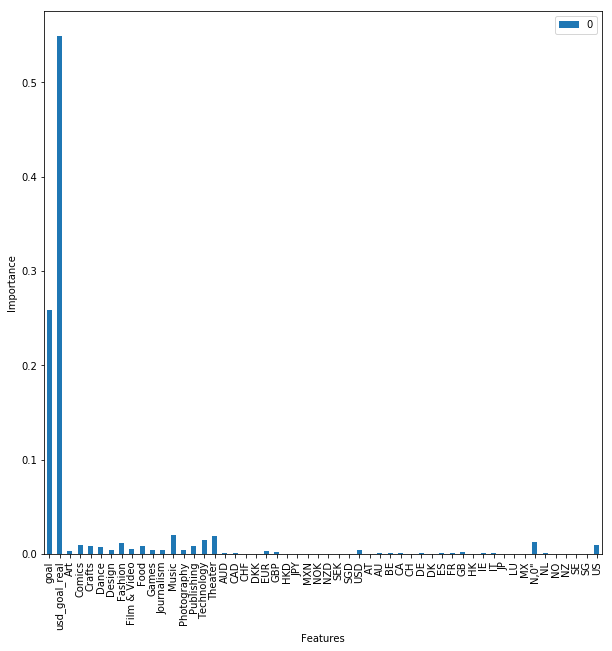

In [58]:
# 説明変数の重要度を出力する
# scikit-learnで算出される重要度は、ある説明変数による不純度の減少量合計である。
print(clf.feature_importances_)
pd.DataFrame(clf.feature_importances_, index=inp.columns).plot.bar(figsize=(10,10))
plt.ylabel("Importance")
plt.xlabel("Features")
plt.show()

### Ada Boostでの確認

In [62]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

n_est_list = [1,10,50,100]
max_depth_list = [1,10,50,100]

res_df = pd.DataFrame(columns=['n_est', 'max_dep', 'validation', 'training'])

for n_est in n_est_list:
    for max_dep in max_depth_list:
        clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=max_dep,
                                                                                 min_samples_leaf=2,
                                                                                 min_samples_split=2, 
                                                                                 random_state=1234,
                                                                                 criterion="gini"),
                                           n_estimators=n_est, random_state=1234)
        clf.fit(X_train, y_train)
        print("Train score=", clf.score(X_train, y_train))
        print("Validation score=", clf.score(X_test, y_test))
        tmp_se = pd.Series( [ n_est, max_dep, clf.score(X_test, y_test), clf.score(X_train, y_train) ], index=res_df.columns )
        res_df = res_df.append( tmp_se , ignore_index=True)


Train score= 0.6432892456990446
Validation score= 0.6448591914650207
Train score= 0.6708758883763623
Validation score= 0.6672608516355606
Train score= 0.7210972133998916
Validation score= 0.6589333936386734
Train score= 0.72191200875323
Validation score= 0.6589999068814602
Train score= 0.6620661214743473
Validation score= 0.6635361100395089
Train score= 0.6832441492705087
Validation score= 0.6705066978835487
Train score= 0.7439680201138053
Validation score= 0.6544770063719687
Train score= 0.744885912022056
Validation score= 0.655873784470488
Train score= 0.6706696952665379
Validation score= 0.6701342237239435
Train score= 0.6955691761254984
Validation score= 0.6659172841312705
Train score= 0.744885912022056
Validation score= 0.6549159937743605
Train score= 0.744885912022056
Validation score= 0.6555811262022269
Train score= 0.6708426314231648
Validation score= 0.6706397243691219
Train score= 0.7090981046862372
Validation score= 0.6619930028068588
Train score= 0.744885912022056
Validatio

In [63]:
#TrainingScoreが大きくなる組み合わせを探すためにTraingScoreを整形して確認
res_df['training'].values.reshape(4,4)

array([[0.64328925, 0.67087589, 0.72109721, 0.72191201],
       [0.66206612, 0.68324415, 0.74396802, 0.74488591],
       [0.6706697 , 0.69556918, 0.74488591, 0.74488591],
       [0.67084263, 0.7090981 , 0.74488591, 0.74488591]])

[           nan            nan            nan            nan
            nan 1.28263806e-04            inf            nan
            nan            nan            nan            nan
            nan            nan            nan            nan
            nan 3.60613841e-05 5.82879046e-05 3.20552868e-06
 6.21568929e-06            nan            nan            nan
            nan            nan            nan            nan
 6.21569746e-06 1.40268424e-05            nan 1.78305238e-05
            nan 9.95377076e-06            nan 9.13955756e-06
            nan 4.86600369e-06            nan 9.39261287e-05
            nan            nan 3.10729685e-05            nan
 0.00000000e+00 5.20100482e-06 4.02575801e-06 3.15264732e-04
 5.01549960e-05            nan 7.47006977e-06            nan
 4.46507825e-06            nan]


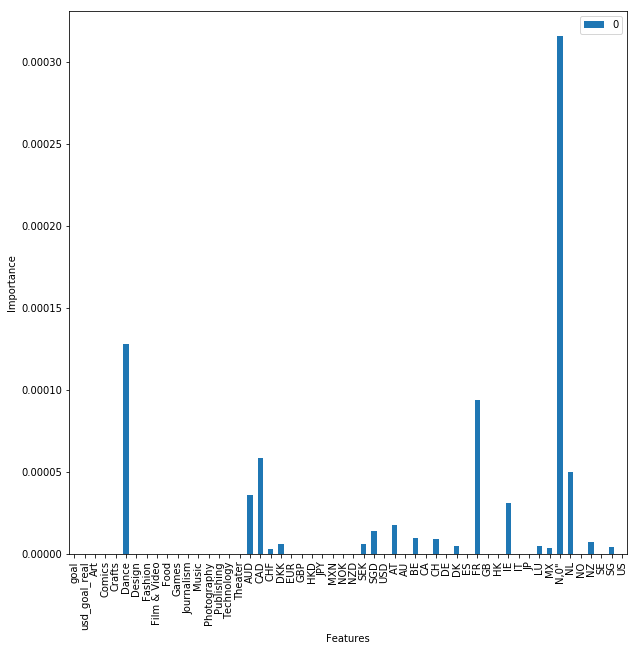

In [64]:
# 説明変数の重要度を出力する
# scikit-learnで算出される重要度は、ある説明変数による不純度の減少量合計である。
print(clf.feature_importances_)
pd.DataFrame(clf.feature_importances_, index=inp.columns).plot.bar(figsize=(10,10))
plt.ylabel("Importance")
plt.xlabel("Features")
plt.show()

- AdaBoostでも特に精度の改善は見られなかった

### ニューラルネットワーク
ニューラルネットワークでの精度を確認する

In [67]:
#y を　one-hot vectorに変換する
from keras.utils import np_utils
y_train_one_hot = np_utils.to_categorical(y_train)
y_test_one_hot = np_utils.to_categorical(y_test)

In [73]:
# 乱数シード値を固定する
import os
import numpy as np
import random as rn
import tensorflow as tf

os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(7)
rn.seed(7)

session_conf = tf.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1
)

from keras import backend as K

tf.set_random_seed(7)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

Train on 300689 samples, validate on 75173 samples
Epoch 1/5
300689/300689 [==============================] - 27s 90us/step - loss: 9.8911 - acc: 0.3860 - val_loss: 10.3890 - val_acc: 0.3552
Epoch 2/5
300689/300689 [==============================] - 27s 89us/step - loss: 6.7364 - acc: 0.5819 - val_loss: 5.7242 - val_acc: 0.6449
Epoch 3/5
300689/300689 [==============================] - 28s 92us/step - loss: 5.7495 - acc: 0.6433 - val_loss: 5.7242 - val_acc: 0.6449
Epoch 4/5
300689/300689 [==============================] - 28s 93us/step - loss: 5.7495 - acc: 0.6433 - val_loss: 5.7242 - val_acc: 0.6449
Epoch 5/5
300689/300689 [==============================] - 27s 90us/step - loss: 5.7495 - acc: 0.6433 - val_loss: 5.7242 - val_acc: 0.6449


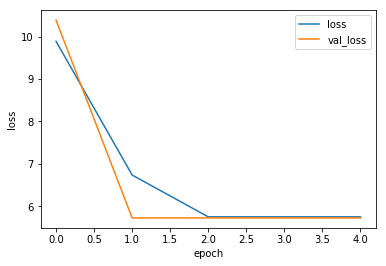

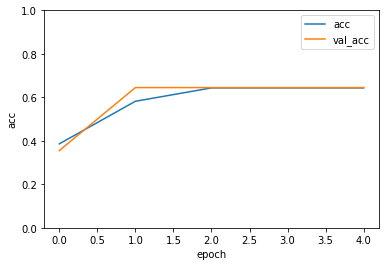

In [76]:
#epochを変えてみる
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD,RMSprop, Adagrad, Adadelta, Adam
from keras.utils import np_utils

model = Sequential()
model.add(Dense(200, activation='relu', input_dim=54))
model.add(Dense(150, activation='relu', input_dim=200))
model.add(Dense(2, activation='softmax'))#最終層のactivationは変更しないこと

# ------ 最適化手法 ------
sgd = SGD(lr=0.01, momentum=0.9, nesterov=False)
# rms = RMSprop(lr=0.01)
# adag = Adagrad(lr=0.01)
# adad = Adadelta(lr=0.01)
#adam = Adam(lr=0.01)
# -----------------------------

model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

# 計算の実行
fit = model.fit(X_train, y_train_one_hot,
          epochs=5,
          batch_size=20,validation_data=(X_test, y_test_one_hot))

# 各epochにおける損失と精度をdfに入れる
df = pd.DataFrame(fit.history)

# グラフ化
df[["loss", "val_loss"]].plot()
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

df[["acc", "val_acc"]].plot()
plt.ylabel("acc")
plt.xlabel("epoch")
plt.ylim([0,1.0])
plt.show()

### 考察
いくつかのアルゴリズムで分類を行ったが、訓練誤差が減少しない。

- 変数が不足しており、十分に学習できなかったことが原因と考えられる
- 変数を追加して精度が向上するかどうかを確認する

### 変数の追加

In [79]:
#データの読込
df = pd.read_csv("./ks-projects-201801.csv")

#評価基準の統一のため、データの加工方法を統一する
df = df[df["state"]!="live"]
df["state"] = df["state"]=="successful"

#開始時にはわからないデータを除去する
df = df.drop('pledged', axis=1)
df = df.drop('backers', axis=1)
df = df.drop('usd pledged', axis=1)
df = df.drop('usd_pledged_real', axis=1)

df_input = pd.concat([df, pd.get_dummies(df['main_category'])], axis=1)
df_input = pd.concat([df_input, pd.get_dummies(df_input['currency'])], axis=1)
df_input = pd.concat([df_input, pd.get_dummies(df_input['country'])], axis=1)

df.head()

,ID,name,category,main_category,currency,deadline,goal,launched,state,country,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,False,GB,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,False,US,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,False,US,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,False,US,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,False,US,19500.00


#### データ変換の方針
- deadline / launchedについて数値データに変換する　（それぞれについて頻度解析する）


In [106]:
#deadlineを日付型に変換
pd.to_datetime(df['deadline'],format='%Y-%m-%d').describe()

count                  375862
unique                   3149
top       2014-08-08 00:00:00
freq                      705
first     2009-05-03 00:00:00
last      2018-02-24 00:00:00
Name: deadline, dtype: object

In [93]:
#deadlineを日付型に変換
pd.to_datetime(df['launched'],format='%Y-%m-%d %H:%M:%S').describe()

count                  375862
unique                 375293
top       1970-01-01 01:00:00
freq                        7
first     1970-01-01 01:00:00
last      2018-01-02 03:05:10
Name: launched, dtype: object

In [91]:
df['deadline_date'] = pd.to_datetime(df['deadline'],format='%Y-%m-%d')
df['launched_date'] = pd.to_datetime(df['launched'],format='%Y-%m-%d %H:%M:%S')

In [92]:
df.head()

,ID,name,category,main_category,currency,deadline,goal,launched,state,country,usd_goal_real,deadline_date,launched_date
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,False,GB,1533.95,2015-10-09,2015-08-11 12:12:28
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,False,US,30000.00,2017-11-01,2017-09-02 04:43:57
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,False,US,45000.00,2013-02-26,2013-01-12 00:20:50
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,False,US,5000.00,2012-04-16,2012-03-17 03:24:11
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,False,US,19500.00,2015-08-29,2015-07-04 08:35:03


### 日付から得られそうなこと
- 開始時期の景気に左右される？　→　launchedの年と成功失敗の関係で差が出ないか？
- launchedが1970年になっているデータはそもそも設立できていない= failed?
- ファンドの募集期間と失敗成功に相関はないか？

In [133]:
#まずはdeadlineと失敗成功の関係を見てみる
df[df['state']==True]['deadline_date'].tail()

378642   2017-10-31
378644   2015-12-15
378646   2013-11-30
378651   2014-03-22
378652   2015-04-28
Name: deadline_date, dtype: datetime64[ns]

In [125]:
df_deadlinecnt_byYear = pd.DataFrame(columns=['success', 'failed', 'ratio'])
df_deadlinecnt_byYear['success'] = df[df['state']==True].groupby(df.deadline_date.dt.year).count().deadline_date

In [126]:
df[df['state']==False].groupby(df.deadline_date.dt.year).count().deadline_date
df_deadlinecnt_byYear['failed'] = df[df['state']==False].groupby(df.deadline_date.dt.year).count().deadline_date

In [131]:
#各年のプロジェクト成功率を出してみる
df_deadlinecnt_byYear['ratio'] = df_deadlinecnt_byYear['success'] / (df_deadlinecnt_byYear['failed'] + df_deadlinecnt_byYear['success'])

In [132]:
df_deadlinecnt_byYear

,success,failed,ratio
deadline_date,,,
2009,384,518,0.425721
2010,4008,5090,0.440536
2011,11768,13339,0.468714
2012,18063,23497,0.434625
2013,19198,24980,0.434560
2014,21202,45029,0.320122
2015,21075,56423,0.271943
2016,18824,39248,0.324149
2017,19348,33388,0.366884


#### deadlineと失敗成功の関係についての考察
- 年によって成功率が極端に低いケースがある　→　ある程度これを加えることによって効果はありそう

In [134]:
df_launcedcnt_byYear = pd.DataFrame(columns=['success', 'failed', 'ratio'])
df_launcedcnt_byYear['success'] = df[df['state']==True].groupby(df.launched_date.dt.year).count().launched_date
df_launcedcnt_byYear['failed'] = df[df['state']==False].groupby(df.launched_date.dt.year).count().launched_date
#各年のプロジェクト成功率を出してみる
df_launcedcnt_byYear['ratio'] = df_launcedcnt_byYear['success'] / (df_launcedcnt_byYear['failed'] + df_launcedcnt_byYear['success'])
df_launcedcnt_byYear

,success,failed,ratio
launched_date,,,
2009,579,750,0.435666
2010,4593,5926,0.436638
2011,12171,14066,0.463887
2012,17892,23273,0.434641
2013,19415,25436,0.432878
2014,21107,46638,0.311565
2015,20971,56329,0.271294
2016,18766,38416,0.328180
2017,18462,31063,0.372781


In [136]:
df[df['state']==False].groupby(df.launched_date.dt.year).count().launched_date

launched_date
1970        7
2009      750
2010     5926
2011    14066
2012    23273
2013    25436
2014    46638
2015    56329
2016    38416
2017    31063
2018        2
Name: launched_date, dtype: int64

#### launched についての考察
- launchedについてもdeadlineと同様の傾向
- ただし、1970年（おそらく未入力）の項目は必ず失敗している（応募前にキャンセルされた？）

In [139]:
# 募集期間という観点で　deadline　- launched の値が使えないか確認する
df['duration'] = df['deadline_date'] - df['launched_date']

In [142]:
#durationの範囲を見てみる
df['duration'].describe()

count                     375862
mean     33 days 21:01:08.022633
std      66 days 03:31:42.820764
min              0 days 00:07:17
25%             29 days 02:18:44
50%      29 days 16:24:21.500000
75%      36 days 07:35:12.750000
max          16738 days 23:00:00
Name: duration, dtype: object

### 上記の解析結果を踏まえた分類結果

In [170]:
#日付関連のデータを含めてデータを再構成する
#データの読込
df = pd.read_csv("./ks-projects-201801.csv")

#評価基準の統一のため、データの加工方法を統一する
df = df[df["state"]!="live"]
df["state"] = df["state"]=="successful"

#開始時にはわからないデータを除去する
df = df.drop('pledged', axis=1)
df = df.drop('backers', axis=1)
df = df.drop('usd pledged', axis=1)
df = df.drop('usd_pledged_real', axis=1)

df['deadline_date'] = pd.to_datetime(df['deadline'],format='%Y-%m-%d').astype('int64') // 10**9
df['launched_date'] = pd.to_datetime(df['launched'],format='%Y-%m-%d %H:%M:%S').astype('int64') // 10**9
# 募集期間という観点で　deadline　- launched の値が使えないか確認する
df['duration'] = (df['deadline_date'] - df['launched_date']).astype('int64') // 10**9

df_input = pd.concat([df, pd.get_dummies(df['main_category'])], axis=1)
df_input = pd.concat([df_input, pd.get_dummies(df_input['currency'])], axis=1)
df_input = pd.concat([df_input, pd.get_dummies(df_input['country'])], axis=1)

y = df_input["state"].values

inp = df_input.drop(['state','ID', 'goal', 'launched', 'deadline','name','category','deadline','launched', 'main_category', 'currency', 'country'], axis=1)
X = inp.values
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234)

In [175]:
#標準化を実行する
# 標準化
from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

In [177]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
clf = DecisionTreeClassifier(criterion="gini", max_depth=None, min_samples_split=10, min_samples_leaf=10, random_state=1234)
#決定木の場合は標準化が不要のため、標準化を実施せずに実行する
clf = clf.fit(X_train_std, y_train)
print("validation score=", clf.score(X_test_std, y_test))
print("training score=", clf.score(X_train_std, y_train))

validation score= 0.6356803639604646
training score= 0.7721466365580384


[2.92379373e-01 2.49780226e-01 2.96807702e-01 0.00000000e+00
 4.06207537e-03 1.13712334e-02 6.15616822e-03 5.62670640e-03
 5.93647810e-03 1.09002415e-02 7.42841774e-03 5.53739705e-03
 5.68591469e-03 2.94346609e-03 1.32031793e-02 4.30470106e-03
 1.33658636e-02 9.95170506e-03 1.37238202e-02 6.99947555e-04
 1.61411720e-03 9.03113595e-05 6.44778931e-05 3.07967386e-03
 3.85032310e-03 3.53589366e-04 0.00000000e+00 3.87349648e-04
 0.00000000e+00 2.12065778e-04 2.23891042e-04 0.00000000e+00
 4.29868780e-03 5.76155335e-05 3.41341393e-04 3.10535445e-06
 9.69222313e-04 7.71259929e-05 5.70912469e-04 7.93946700e-05
 2.13221129e-04 7.49215077e-04 1.56947255e-03 4.95054596e-05
 1.46246324e-04 8.43588970e-04 0.00000000e+00 0.00000000e+00
 8.08754610e-04 1.43605859e-02 3.21228998e-04 4.64161912e-05
 6.35539548e-05 1.72188422e-04 8.61802535e-05 4.43202122e-03]


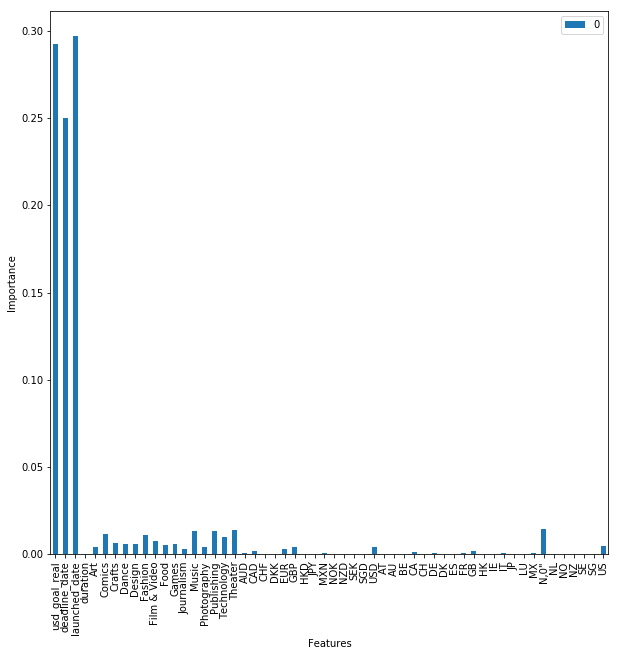

In [178]:
# 説明変数の重要度を出力する
# scikit-learnで算出される重要度は、ある説明変数による不純度の減少量合計である。
print(clf.feature_importances_)
pd.DataFrame(clf.feature_importances_, index=inp.columns).plot.bar(figsize=(10,10))
plt.ylabel("Importance")
plt.xlabel("Features")
plt.show()

- ある程度重要度がばらけた　→　多少の改善が期待できそう

In [179]:
#y を　one-hot vectorに変換する
from keras.utils import np_utils
y_train_one_hot = np_utils.to_categorical(y_train)
y_test_one_hot = np_utils.to_categorical(y_test)

In [180]:
# 乱数シード値を固定する
import os
import numpy as np
import random as rn
import tensorflow as tf

os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(7)
rn.seed(7)

session_conf = tf.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1
)

from keras import backend as K

tf.set_random_seed(7)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

Train on 300689 samples, validate on 75173 samples
Epoch 1/50
300689/300689 [==============================] - 5s 18us/step - loss: 0.6180 - acc: 0.6604 - val_loss: 0.6108 - val_acc: 0.6659
Epoch 2/50
300689/300689 [==============================] - 4s 15us/step - loss: 0.6083 - acc: 0.6653 - val_loss: 0.6055 - val_acc: 0.6656
Epoch 3/50
300689/300689 [==============================] - 4s 15us/step - loss: 0.6159 - acc: 0.6670 - val_loss: 0.6157 - val_acc: 0.6677
Epoch 4/50
300689/300689 [==============================] - 4s 15us/step - loss: 0.6158 - acc: 0.6690 - val_loss: 0.6139 - val_acc: 0.6696
Epoch 5/50
300689/300689 [==============================] - 4s 15us/step - loss: 0.6144 - acc: 0.6696 - val_loss: 0.6138 - val_acc: 0.6664
Epoch 6/50
300689/300689 [==============================] - 5s 15us/step - loss: 0.6132 - acc: 0.6704 - val_loss: 0.6157 - val_acc: 0.6713
Epoch 7/50
300689/300689 [==============================] - 5s 15us/step - loss: 0.6038 - acc: 0.6722 - val_loss: 0

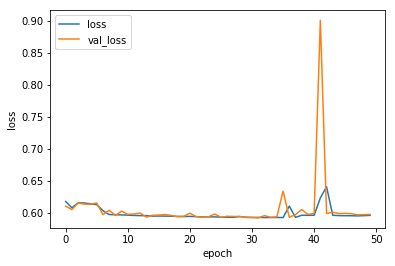

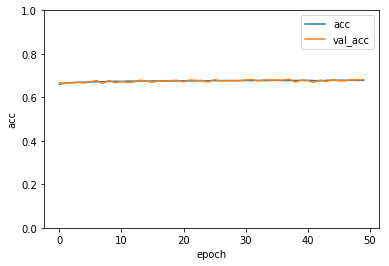

In [191]:
#epochを変えてみる
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD,RMSprop, Adagrad, Adadelta, Adam
from keras.utils import np_utils

model = Sequential()
model.add(Dense(100, activation='relu', input_dim=56))
model.add(Dense(200, activation='relu', input_dim=100))
model.add(Dense(2, activation='softmax'))#最終層のactivationは変更しないこと

# ------ 最適化手法 ------
#sgd = SGD(lr=0.01, momentum=0.9, nesterov=False)
# rms = RMSprop(lr=0.01)
# adag = Adagrad(lr=0.01)
# adad = Adadelta(lr=0.01)
adam = Adam(lr=0.01)
# -----------------------------

model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

# 計算の実行
fit = model.fit(X_train_std, y_train_one_hot,
          epochs=50,
          batch_size=256,validation_data=(X_test_std, y_test_one_hot))

# 各epochにおける損失と精度をdfに入れる
df_res = pd.DataFrame(fit.history)

# グラフ化
df_res[["loss", "val_loss"]].plot()
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

df_res[["acc", "val_acc"]].plot()
plt.ylabel("acc")
plt.xlabel("epoch")
plt.ylim([0,1.0])
plt.show()

- 学習がうまくいっていない？